In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("🍷 Wine Quality Classification - Analysis Notebook")
print("=" * 60)

🍷 Wine Quality Classification - Analysis Notebook


In [48]:
# =============================================================================
# 1. LOAD RESULTS
# =============================================================================

def load_latest_results(results_dir="results", experiment_type="combined_comparison"):
    """Load the most recent experiment results"""
    if not os.path.exists(results_dir):
        print(f"❌ Results directory '{results_dir}' not found!")
        return None

    # Find the latest file
    files = [f for f in os.listdir(results_dir) if experiment_type in f and f.endswith('.pkl')]
    if not files:
        print(f"❌ No {experiment_type} results found in {results_dir}")
        return None

    latest_file = max(files, key=lambda x: os.path.getctime(os.path.join(results_dir, x)))
    file_path = os.path.join(results_dir, latest_file)

    print(f"📂 Loading results from: {latest_file}")

    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    return data


# Load experiment results
results_data = load_latest_results(results_dir="../results")

if results_data is None:
    print("⚠️  No results found. Please run main.py first to generate results.")
    print("   Then restart this notebook.")
else:
    print("✅ Results loaded successfully!")

    # Extract data
    if 'results' in results_data and 'baseline' in results_data['results']:
        # Combined results format
        baseline_results = results_data['results']['baseline']
        smote_results = results_data['results']['smote']
        metadata = results_data['results'].get('metadata', {})
    else:
        # Single experiment format - try to load both baseline and smote
        baseline_data = load_latest_results(experiment_type="baseline")
        smote_data = load_latest_results(experiment_type="smote_oversampling")

        if baseline_data and smote_data:
            baseline_results = baseline_data['results']
            smote_results = smote_data['results']
            metadata = {}
        else:
            print("❌ Could not find both baseline and SMOTE results")
            baseline_results = smote_results = metadata = {}



📂 Loading results from: combined_comparison_20250801_121518.pkl
✅ Results loaded successfully!



📊 DATA OVERVIEW & PREPROCESSING ANALYSIS
🔴 Red wine samples: 1599
⚪ White wine samples: 4898
📈 Total samples: 6497
🔢 Features: 11


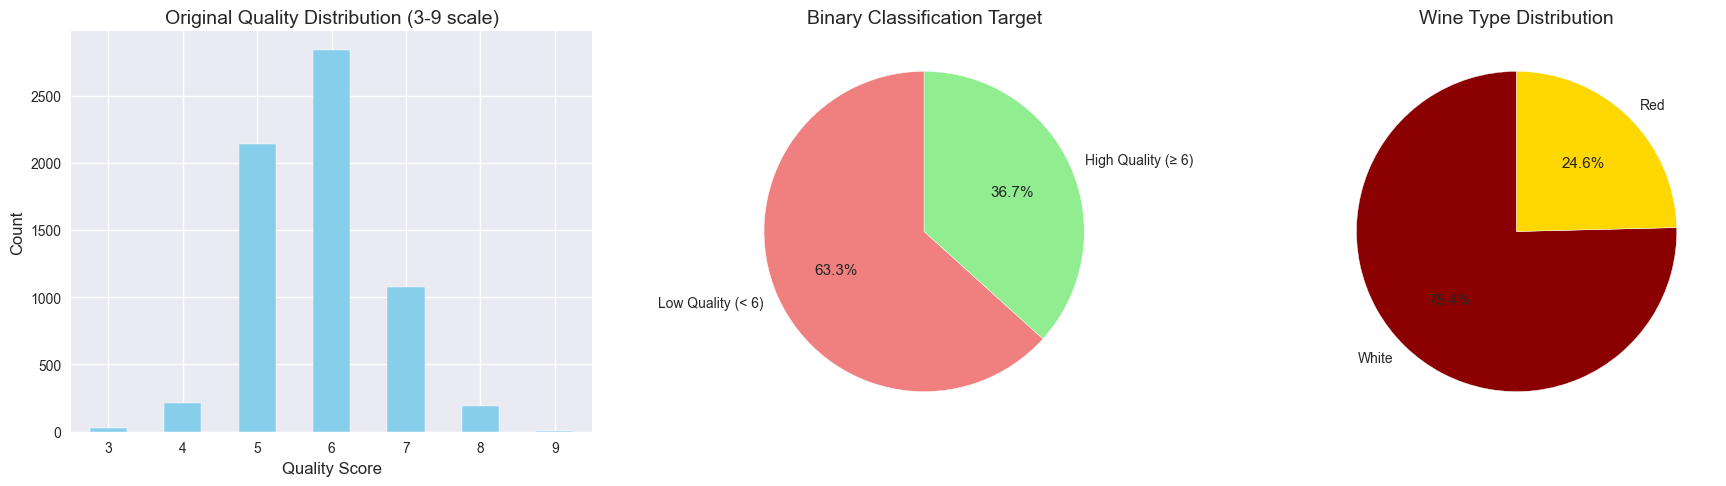


📊 Class Distribution:
   Low Quality (0): 2,384 samples (36.7%)
   High Quality (1): 4,113 samples (63.3%)
   Imbalance Ratio: 1.73:1
   ⚠️  Dataset is imbalanced (ratio > 1.5:1)
   💡 SMOTE oversampling should help address this


In [49]:
# =============================================================================
# 2. DATA OVERVIEW AND PREPROCESSING ANALYSIS
# =============================================================================

def analyze_data_overview():
    """Analyze the original dataset and preprocessing steps"""
    print("\n" + "=" * 60)
    print("📊 DATA OVERVIEW & PREPROCESSING ANALYSIS")
    print("=" * 60)

    # Load original data to analyze
    try:
        red_path = os.path.join("..", "data", "winequality-red.csv")
        white_path = os.path.join("..", "data", "winequality-white.csv")

        red_wine = pd.read_csv(red_path, sep=';')
        white_wine = pd.read_csv(white_path, sep=';')

        print(f"🔴 Red wine samples: {len(red_wine)}")
        print(f"⚪ White wine samples: {len(white_wine)}")
        print(f"📈 Total samples: {len(red_wine) + len(white_wine)}")
        print(f"🔢 Features: {len(red_wine.columns) - 1}")  # -1 for quality column

        # Combine data
        red_wine['wine_type'] = 'red'
        white_wine['wine_type'] = 'white'
        combined_data = pd.concat([red_wine, white_wine], ignore_index=True)

        # Create binary target
        combined_data['quality_binary'] = (combined_data['quality'] >= 6).astype(int)

        # Class distribution analysis
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Original quality distribution
        combined_data['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title('Original Quality Distribution (3-9 scale)')
        axes[0].set_xlabel('Quality Score')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=0)

        # Binary quality distribution
        binary_counts = combined_data['quality_binary'].value_counts()
        axes[1].pie(binary_counts.values, labels=['Low Quality (< 6)', 'High Quality (≥ 6)'],
                    autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
        axes[1].set_title('Binary Classification Target')

        # Wine type distribution
        type_counts = combined_data['wine_type'].value_counts()
        axes[2].pie(type_counts.values, labels=type_counts.index.str.title(),
                    autopct='%1.1f%%', startangle=90, colors=['darkred', 'gold'])
        axes[2].set_title('Wine Type Distribution')

        plt.tight_layout()
        plt.show()

        # Class imbalance analysis
        class_distribution = combined_data['quality_binary'].value_counts()
        imbalance_ratio = class_distribution.max() / class_distribution.min()

        print(f"\n📊 Class Distribution:")
        print(
            f"   Low Quality (0): {class_distribution[0]:,} samples ({class_distribution[0] / len(combined_data) * 100:.1f}%)")
        print(
            f"   High Quality (1): {class_distribution[1]:,} samples ({class_distribution[1] / len(combined_data) * 100:.1f}%)")
        print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

        if imbalance_ratio > 1.5:
            print(f"   ⚠️  Dataset is imbalanced (ratio > 1.5:1)")
            print(f"   💡 SMOTE oversampling should help address this")

        return combined_data

    except FileNotFoundError:
        print(
            "❌ Data files not found. Please ensure winequality-red.csv and winequality-white.csv are in the data/ directory.")
        return None


# Run data analysis
original_data = analyze_data_overview()




🎯 MODEL PERFORMANCE COMPARISON


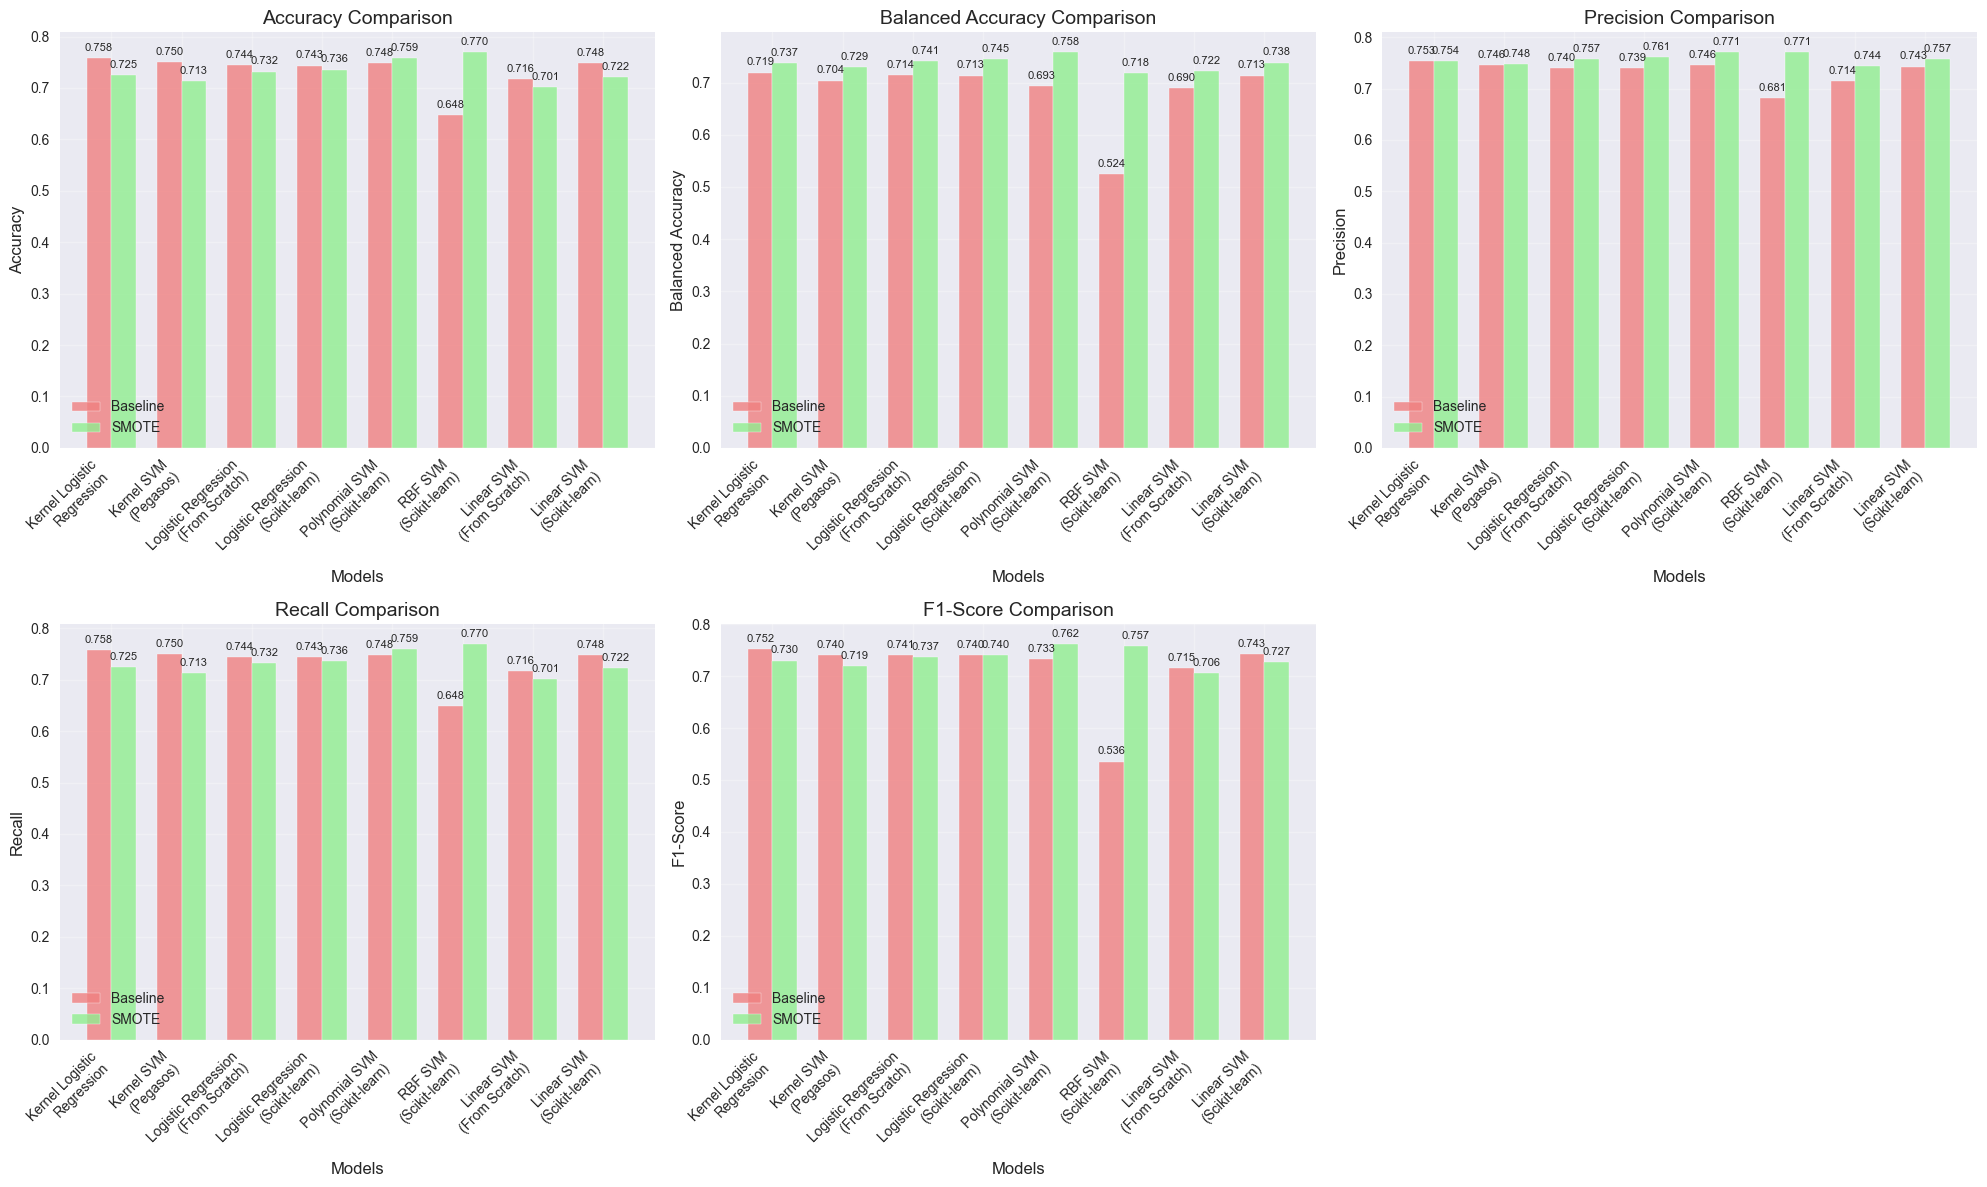


📈 PERFORMANCE IMPROVEMENTS (SMOTE vs Baseline):
------------------------------------------------------------
📉 Kernel SVM (Pegasos)     : F1 -0.0219
📈 RBF SVM (Scikit-learn)   : F1 +0.2217
➖ Linear SVM (From Scratch): F1 -0.0087
📉 Kernel Logistic Regression: F1 -0.0217
📉 Linear SVM (Scikit-learn): F1 -0.0162
📈 Polynomial SVM (Scikit-learn): F1 +0.0287
➖ Logistic Regression (Scikit-learn): F1 -0.0000
➖ Logistic Regression (From Scratch): F1 -0.0045


In [50]:
# =============================================================================
# 3. MODEL PERFORMANCE COMPARISON
# =============================================================================

def create_performance_comparison():
    """Create comprehensive performance comparison visualizations"""
    if not baseline_results or not smote_results:
        print("❌ Results not available for comparison")
        return

    print("\n" + "=" * 60)
    print("🎯 MODEL PERFORMANCE COMPARISON")
    print("=" * 60)

    # Model name mapping for better display
    model_names = {
        'lr_scratch': 'Logistic Regression\n(From Scratch)',
        'lr_sklearn': 'Logistic Regression\n(Scikit-learn)',
        'svm_scratch': 'Linear SVM\n(From Scratch)',
        'svm_sklearn': 'Linear SVM\n(Scikit-learn)',
        'klr_scratch': 'Kernel Logistic\nRegression',
        'ksvm_scratch': 'Kernel SVM\n(Pegasos)',
        'rbf_svm_sklearn': 'RBF SVM\n(Scikit-learn)',
        'poly_svm_sklearn': 'Polynomial SVM\n(Scikit-learn)'
    }

    # Prepare data for plotting
    metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    metric_labels = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Find common models between baseline and SMOTE
    common_models = set(baseline_results.keys()) & set(smote_results.keys())

    if not common_models:
        print("❌ No common models found between baseline and SMOTE results")
        return

    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[i]

        models = []
        baseline_scores = []
        smote_scores = []

        for model_key in sorted(common_models):
            if model_key in baseline_results and model_key in smote_results:
                models.append(model_names.get(model_key, model_key))
                baseline_scores.append(baseline_results[model_key][metric])
                smote_scores.append(smote_results[model_key][metric])

        x = np.arange(len(models))
        width = 0.35

        bars1 = ax.bar(x - width / 2, baseline_scores, width, label='Baseline',
                       color='lightcoral', alpha=0.8)
        bars2 = ax.bar(x + width / 2, smote_scores, width, label='SMOTE',
                       color='lightgreen', alpha=0.8)

        ax.set_xlabel('Models')
        ax.set_ylabel(label)
        ax.set_title(f'{label} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Remove empty subplot
    axes[5].remove()

    plt.tight_layout()
    plt.show()

    # Performance improvement analysis
    print("\n📈 PERFORMANCE IMPROVEMENTS (SMOTE vs Baseline):")
    print("-" * 60)

    improvements = {}
    for model_key in common_models:
        model_name = model_names.get(model_key, model_key).replace('\n', ' ')
        improvements[model_name] = {}

        for metric in metrics:
            baseline_score = baseline_results[model_key][metric]
            smote_score = smote_results[model_key][metric]
            improvement = smote_score - baseline_score
            improvements[model_name][metric] = improvement

        # Print F1 improvements (most important for imbalanced data)
        f1_improvement = improvements[model_name]['f1']
        status = "📈" if f1_improvement > 0.01 else "📉" if f1_improvement < -0.01 else "➖"
        print(f"{status} {model_name:<25}: F1 {f1_improvement:+.4f}")

    return improvements


# Create performance comparison
performance_improvements = create_performance_comparison()




🔍 DETAILED METRICS ANALYSIS


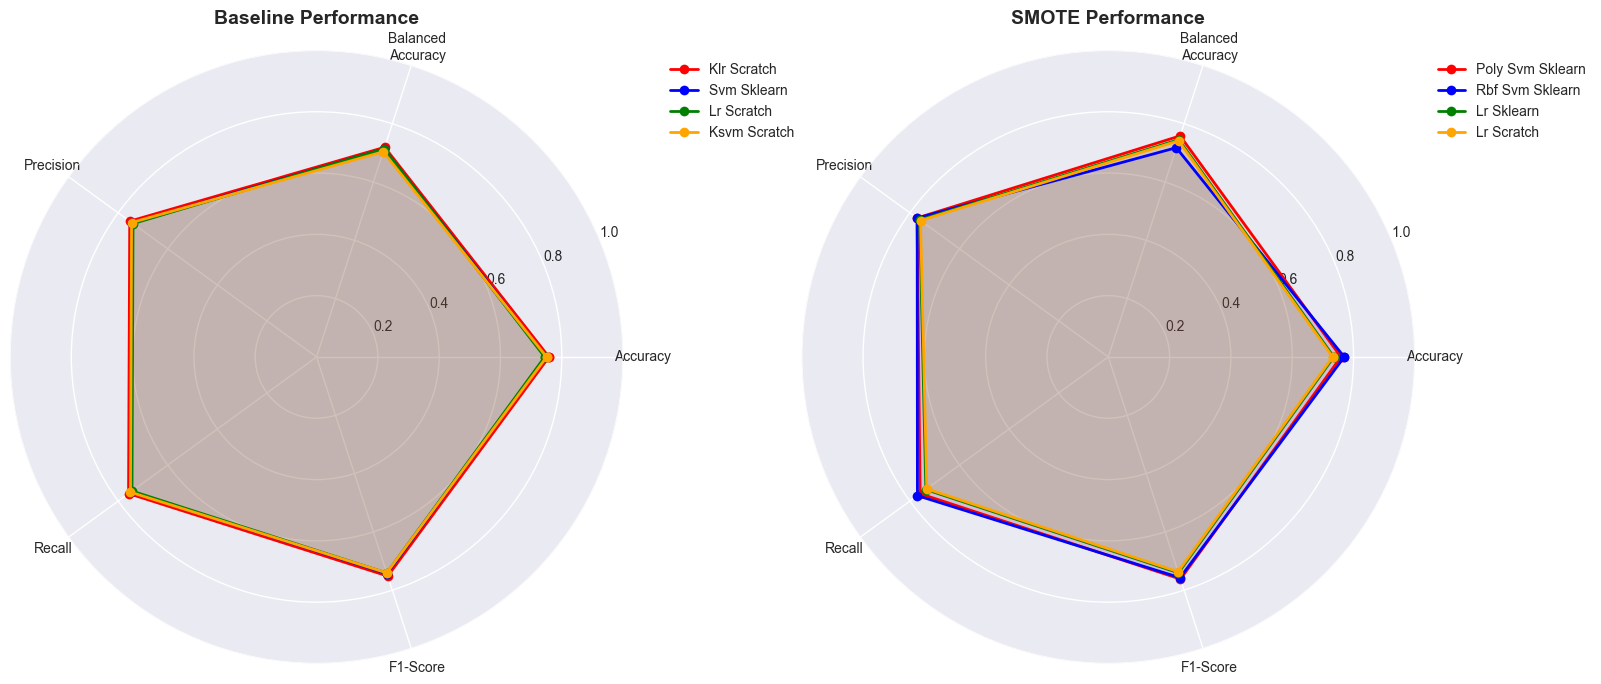

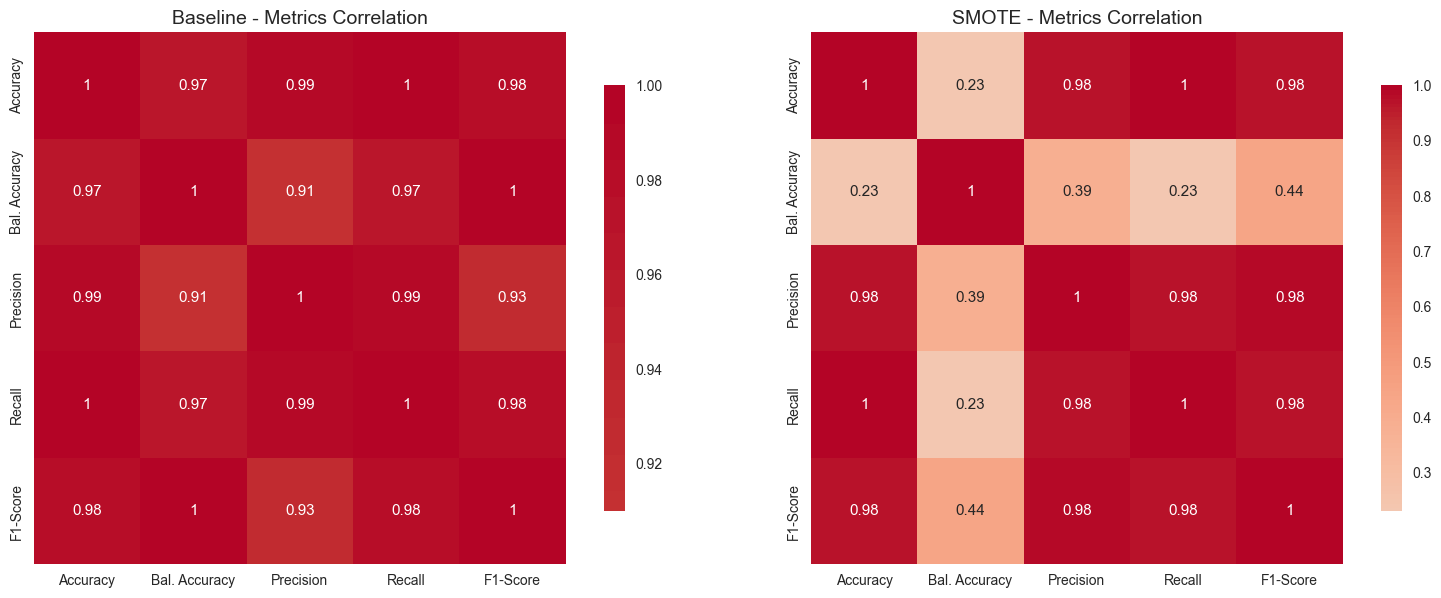

In [51]:
# =============================================================================
# 4. DETAILED METRICS ANALYSIS
# =============================================================================

def analyze_detailed_metrics():
    """Analyze metrics in detail with radar charts and heatmaps"""
    if not baseline_results or not smote_results:
        return

    print("\n" + "=" * 60)
    print("🔍 DETAILED METRICS ANALYSIS")
    print("=" * 60)

    # Create radar chart for top performing models
    from math import pi

    def create_radar_chart(results, title, ax):
        """Create radar chart for model performance"""
        metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
        metric_labels = ['Accuracy', 'Balanced\nAccuracy', 'Precision', 'Recall', 'F1-Score']

        # Find top 4 models by F1 score
        model_f1_scores = {model: results[model]['f1'] for model in results.keys()}
        top_models = sorted(model_f1_scores.items(), key=lambda x: x[1], reverse=True)[:4]

        # Number of variables
        categories = metric_labels
        N = len(categories)

        # Compute angle for each axis
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]  # Complete the circle

        colors = ['red', 'blue', 'green', 'orange']

        for i, (model_key, _) in enumerate(top_models):
            values = [results[model_key][metric] for metric in metrics]
            values += values[:1]  # Complete the circle

            model_name = model_key.replace('_', ' ').title()
            ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
            ax.fill(angles, values, alpha=0.1, color=colors[i])

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title(title, size=14, fontweight='bold')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)

    # Create radar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(projection='polar'))

    create_radar_chart(baseline_results, 'Baseline Performance', ax1)
    create_radar_chart(smote_results, 'SMOTE Performance', ax2)

    plt.tight_layout()
    plt.show()

    # Metrics correlation heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    def create_metrics_heatmap(results, title, ax):
        """Create correlation heatmap of metrics across models"""
        metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

        # Create dataframe with metrics for each model
        data = []
        for model in results.keys():
            row = [results[model][metric] for metric in metrics]
            data.append(row)

        df = pd.DataFrame(data,
                          columns=['Accuracy', 'Bal. Accuracy', 'Precision', 'Recall', 'F1-Score'],
                          index=list(results.keys()))

        # Compute correlation matrix
        corr_matrix = df.corr()

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, ax=ax, cbar_kws={'shrink': 0.8})
        ax.set_title(f'{title} - Metrics Correlation')

    create_metrics_heatmap(baseline_results, 'Baseline', ax1)
    create_metrics_heatmap(smote_results, 'SMOTE', ax2)

    plt.tight_layout()
    plt.show()


# Run detailed metrics analysis
analyze_detailed_metrics()




🏗️ MODEL ARCHITECTURE ANALYSIS


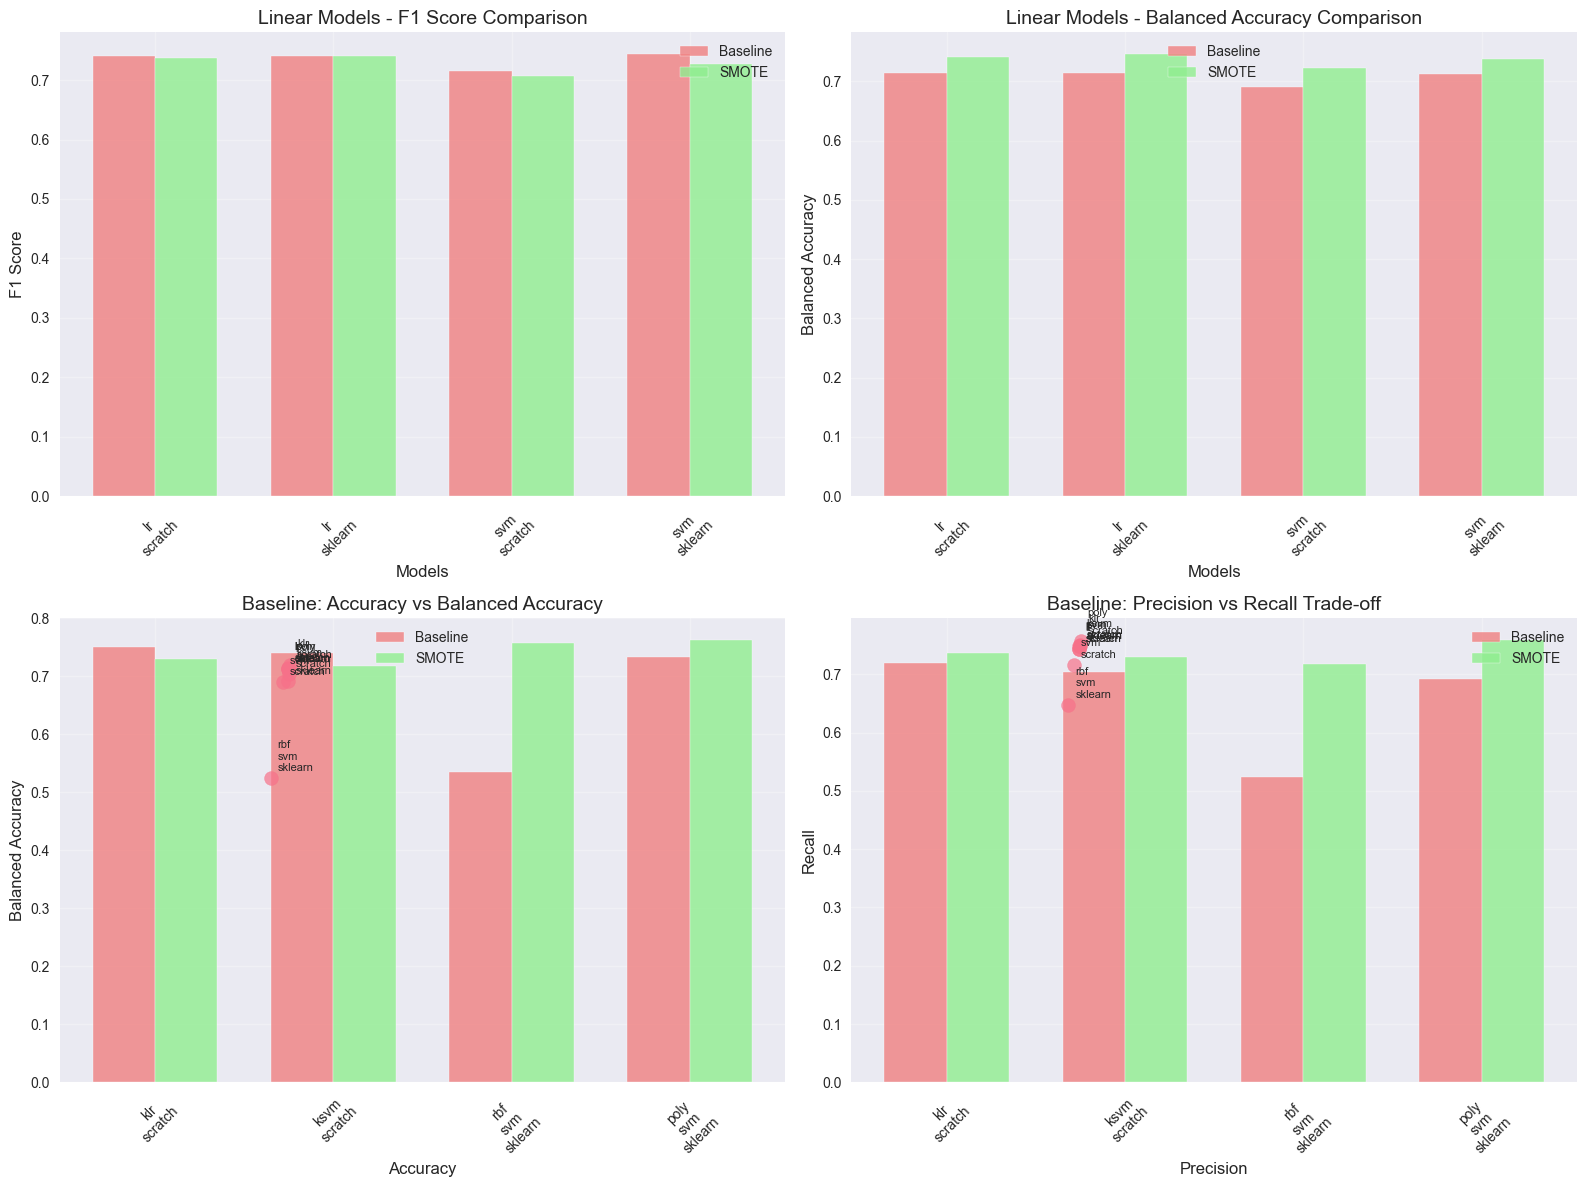

🔍 FITTING BEHAVIOR ANALYSIS:
----------------------------------------

📊 Lr Scratch:

📊 Lr Sklearn:

📊 Svm Scratch:

📊 Svm Sklearn:

📊 Klr Scratch:
   ❌ SMOTE hurt performance (-0.022)
      → Model was already handling imbalance well

📊 Ksvm Scratch:
   ❌ SMOTE hurt performance (-0.022)
      → Model was already handling imbalance well

📊 Rbf Svm Sklearn:
   ⚠️  Potential overfitting: Accuracy (0.648) >> Balanced Accuracy (0.524)
      → Model may be biased toward majority class
   📉 Low F1-score (0.536) suggests underfitting
      → Consider more complex model or better features
   ✅ SMOTE significantly improved F1 (+0.222)
      → Original model suffered from class imbalance

📊 Poly Svm Sklearn:
   ⚠️  Potential overfitting: Accuracy (0.748) >> Balanced Accuracy (0.693)
      → Model may be biased toward majority class
   ✅ SMOTE significantly improved F1 (+0.029)
      → Original model suffered from class imbalance


In [52]:
# =============================================================================
# 5. MODEL ARCHITECTURE ANALYSIS
# =============================================================================

def analyze_model_architectures():
    """Analyze different model architectures and their characteristics"""
    print("\n" + "=" * 60)
    print("🏗️ MODEL ARCHITECTURE ANALYSIS")
    print("=" * 60)

    # Group models by type
    model_groups = {
        'Linear Models': ['lr_scratch', 'lr_sklearn', 'svm_scratch', 'svm_sklearn'],
        'Kernel Methods': ['klr_scratch', 'ksvm_scratch', 'rbf_svm_sklearn', 'poly_svm_sklearn']
    }

    if not baseline_results:
        return

    # Get all available models
    all_models = list(baseline_results.keys())

    # Filter models that exist in both baseline and smote results
    common_models = [m for m in all_models if
                     m in baseline_results and m in smote_results] if smote_results else all_models

    # Analyze performance by model type
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for i, (group_name, models) in enumerate(model_groups.items()):
        row = i

        # Filter models that exist in results
        existing_models = [m for m in models if m in baseline_results]
        if not existing_models:
            continue

        # F1 scores comparison
        ax1 = axes[row, 0]
        baseline_f1 = [baseline_results[m]['f1'] for m in existing_models if m in baseline_results]
        smote_f1 = [smote_results[m]['f1'] for m in existing_models if m in smote_results] if smote_results else []

        x = np.arange(len(existing_models))
        width = 0.35

        ax1.bar(x - width / 2, baseline_f1, width, label='Baseline', color='lightcoral', alpha=0.8)
        if smote_f1:
            ax1.bar(x + width / 2, smote_f1, width, label='SMOTE', color='lightgreen', alpha=0.8)

        ax1.set_title(f'{group_name} - F1 Score Comparison')
        ax1.set_xlabel('Models')
        ax1.set_ylabel('F1 Score')
        ax1.set_xticks(x)
        ax1.set_xticklabels([m.replace('_', '\n') for m in existing_models], rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Balanced accuracy comparison
        ax2 = axes[row, 1]
        baseline_bal_acc = [baseline_results[m]['balanced_accuracy'] for m in existing_models if m in baseline_results]
        smote_bal_acc = [smote_results[m]['balanced_accuracy'] for m in existing_models if
                         m in smote_results] if smote_results else []

        ax2.bar(x - width / 2, baseline_bal_acc, width, label='Baseline', color='lightcoral', alpha=0.8)
        if smote_bal_acc:
            ax2.bar(x + width / 2, smote_bal_acc, width, label='SMOTE', color='lightgreen', alpha=0.8)

        ax2.set_title(f'{group_name} - Balanced Accuracy Comparison')
        ax2.set_xlabel('Models')
        ax2.set_ylabel('Balanced Accuracy')
        ax2.set_xticks(x)
        ax2.set_xticklabels([m.replace('_', '\n') for m in existing_models], rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Create scatter plots for the bottom row
    # 1. Baseline: Accuracy vs Balanced Accuracy
    ax3 = axes[1, 0]
    accuracy_scores = [baseline_results[m]['accuracy'] for m in common_models]
    balanced_accuracy_scores = [baseline_results[m]['balanced_accuracy'] for m in common_models]

    ax3.scatter(accuracy_scores, balanced_accuracy_scores, alpha=0.7, s=100)
    ax3.set_xlabel('Accuracy')
    ax3.set_ylabel('Balanced Accuracy')
    ax3.set_title('Baseline: Accuracy vs Balanced Accuracy')
    ax3.grid(True, alpha=0.3)

    # Add model labels
    for i, model in enumerate(common_models):
        ax3.annotate(model.replace('_', '\n'),
                     (accuracy_scores[i], balanced_accuracy_scores[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    # 2. Precision vs Recall analysis (indicates class bias issues)
    ax4 = axes[1, 1]
    precision_scores = [baseline_results[m]['precision'] for m in common_models]
    recall_scores = [baseline_results[m]['recall'] for m in common_models]

    ax4.scatter(precision_scores, recall_scores, alpha=0.7, s=100)
    ax4.set_xlabel('Precision')
    ax4.set_ylabel('Recall')
    ax4.set_title('Baseline: Precision vs Recall Trade-off')
    ax4.grid(True, alpha=0.3)

    # Add model labels
    for i, model in enumerate(common_models):
        ax4.annotate(model.replace('_', '\n'),
                     (precision_scores[i], recall_scores[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Fitting behavior analysis
    print("🔍 FITTING BEHAVIOR ANALYSIS:")
    print("-" * 40)

    # Identify potential overfitting/underfitting patterns
    for model in common_models:
        if model not in baseline_results:
            continue

        accuracy = baseline_results[model]['accuracy']
        balanced_accuracy = baseline_results[model]['balanced_accuracy']
        precision = baseline_results[model]['precision']
        recall = baseline_results[model]['recall']
        f1 = baseline_results[model]['f1']

        # Analysis criteria
        acc_bal_diff = accuracy - balanced_accuracy
        precision_recall_diff = abs(precision - recall)

        print(f"\n📊 {model.replace('_', ' ').title()}:")

        # Overfitting indicators
        if acc_bal_diff > 0.05:
            print(
                f"   ⚠️  Potential overfitting: Accuracy ({accuracy:.3f}) >> Balanced Accuracy ({balanced_accuracy:.3f})")
            print(f"      → Model may be biased toward majority class")

        # Class imbalance handling
        if precision_recall_diff > 0.1:
            if precision > recall:
                print(f"   📈 High precision ({precision:.3f}), lower recall ({recall:.3f})")
                print(f"      → Conservative predictions (few false positives)")
            else:
                print(f"   📈 High recall ({recall:.3f}), lower precision ({precision:.3f})")
                print(f"      → Liberal predictions (few false negatives)")

        # Overall performance assessment
        if f1 < 0.7:
            print(f"   📉 Low F1-score ({f1:.3f}) suggests underfitting")
            print(f"      → Consider more complex model or better features")
        elif f1 > 0.85:
            print(f"   🎯 Excellent F1-score ({f1:.3f}) - well-fitted model")

        # SMOTE improvement analysis
        if smote_results and model in smote_results:
            smote_f1 = smote_results[model]['f1']
            smote_bal_acc = smote_results[model]['balanced_accuracy']

            f1_improvement = smote_f1 - f1
            bal_acc_improvement = smote_bal_acc - balanced_accuracy

            if f1_improvement > 0.02:
                print(f"   ✅ SMOTE significantly improved F1 (+{f1_improvement:.3f})")
                print(f"      → Original model suffered from class imbalance")
            elif f1_improvement < -0.02:
                print(f"   ❌ SMOTE hurt performance ({f1_improvement:.3f})")
                print(f"      → Model was already handling imbalance well")


analyze_model_architectures()




📈 OVERFITTING/UNDERFITTING ANALYSIS


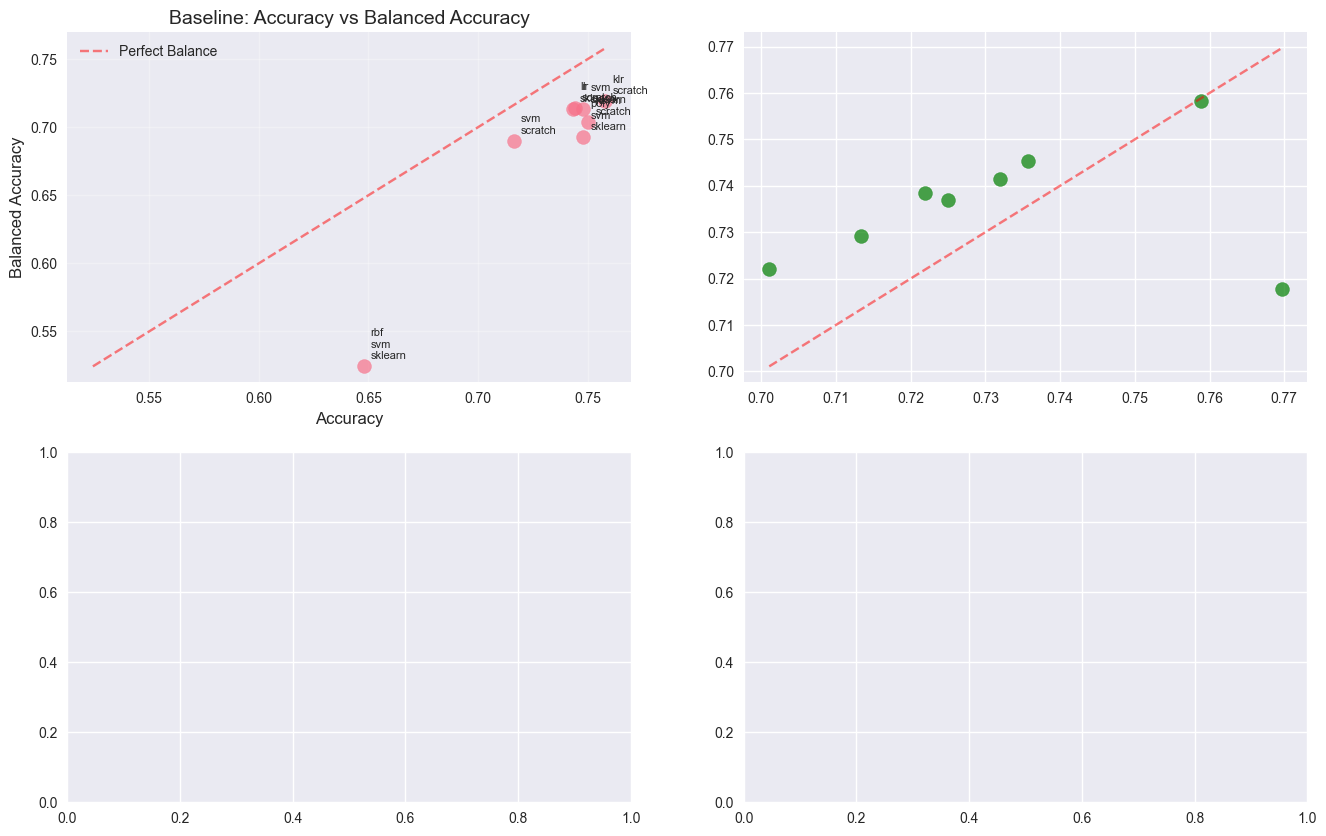

In [53]:
# =============================================================================
# 6. OVERFITTING/UNDERFITTING ANALYSIS
# =============================================================================

def analyze_fitting_behavior():
    """Analyze overfitting and underfitting patterns"""
    print("\n" + "=" * 60)
    print("📈 OVERFITTING/UNDERFITTING ANALYSIS")
    print("=" * 60)

    if not baseline_results:
        return

    # Analyze performance patterns that indicate overfitting/underfitting

    # 1. Compare accuracy vs balanced accuracy (balanced accuracy drops more with overfitting)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Baseline analysis
    models = list(baseline_results.keys())
    accuracy_scores = [baseline_results[m]['accuracy'] for m in models]
    balanced_accuracy_scores = [baseline_results[m]['balanced_accuracy'] for m in models]

    ax1 = axes[0, 0]
    ax1.scatter(accuracy_scores, balanced_accuracy_scores, alpha=0.7, s=100)

    # Add diagonal line (perfect balance)
    min_score = min(min(accuracy_scores), min(balanced_accuracy_scores))
    max_score = max(max(accuracy_scores), max(balanced_accuracy_scores))
    ax1.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.5, label='Perfect Balance')

    ax1.set_xlabel('Accuracy')
    ax1.set_ylabel('Balanced Accuracy')
    ax1.set_title('Baseline: Accuracy vs Balanced Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add model labels
    for i, model in enumerate(models):
        ax1.annotate(model.replace('_', '\n'),
                     (accuracy_scores[i], balanced_accuracy_scores[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    # SMOTE analysis
    if smote_results:
        smote_accuracy_scores = [smote_results[m]['accuracy'] for m in models if m in smote_results]
        smote_balanced_accuracy_scores = [smote_results[m]['balanced_accuracy'] for m in models if m in smote_results]
        smote_models = [m for m in models if m in smote_results]

        ax2 = axes[0, 1]
        ax2.scatter(smote_accuracy_scores, smote_balanced_accuracy_scores, alpha=0.7, s=100, color='green')

        min_score = min(min(smote_accuracy_scores), min(smote_balanced_accuracy_scores))
        max_score = max(max(smote_accuracy_scores), max(smote_balanced_accuracy_scores))
        ax2.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.5, label='Perfect Balance')


analyze_fitting_behavior()




🔍 MISCLASSIFICATION ANALYSIS
📋 MISCLASSIFICATION PATTERNS (Conceptual Analysis):
--------------------------------------------------


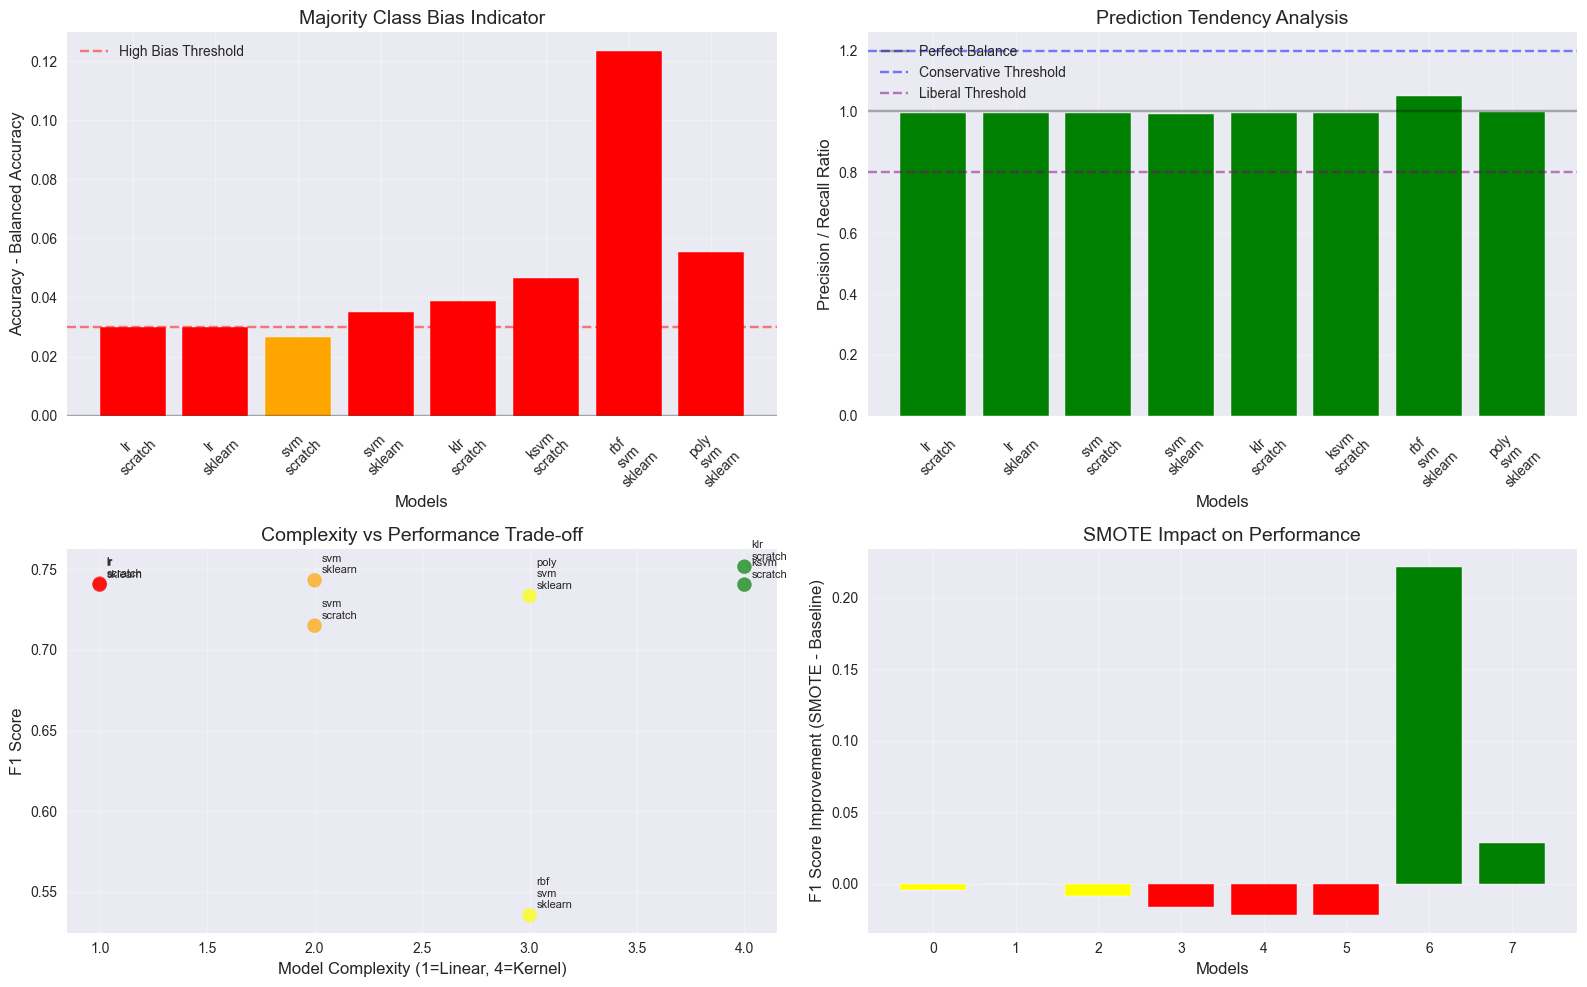

In [54]:
# =============================================================================
# 7. MISCLASSIFICATION ANALYSIS
# =============================================================================

def analyze_misclassifications():
    """Analyze patterns in misclassified examples"""
    print("\n" + "=" * 60)
    print("🔍 MISCLASSIFICATION ANALYSIS")
    print("=" * 60)

    # Note: This is a conceptual analysis since we don't have access to individual predictions
    # In a real scenario, you would retrain models and capture prediction details

    print("📋 MISCLASSIFICATION PATTERNS (Conceptual Analysis):")
    print("-" * 50)

    if not baseline_results:
        return

    # Analyze performance patterns to infer misclassification issues
    models_analysis = {}

    for model in baseline_results.keys():
        accuracy = baseline_results[model]['accuracy']
        balanced_accuracy = baseline_results[model]['balanced_accuracy']
        precision = baseline_results[model]['precision']
        recall = baseline_results[model]['recall']

        analysis = {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'precision': precision,
            'recall': recall,
            'accuracy_gap': accuracy - balanced_accuracy,
            'precision_recall_ratio': precision / recall if recall > 0 else 0
        }

        models_analysis[model] = analysis

    # Create visualization of misclassification patterns
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Accuracy vs Balanced Accuracy Gap (indicates majority class bias)
    ax1 = axes[0, 0]
    models = list(models_analysis.keys())
    accuracy_gaps = [models_analysis[m]['accuracy_gap'] for m in models]

    bars = ax1.bar(range(len(models)), accuracy_gaps,
                   color=['red' if gap > 0.03 else 'orange' if gap > 0.01 else 'green' for gap in accuracy_gaps])
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy - Balanced Accuracy')
    ax1.set_title('Majority Class Bias Indicator')
    ax1.set_xticks(range(len(models)))
    ax1.set_xticklabels([m.replace('_', '\n') for m in models], rotation=45)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.axhline(y=0.03, color='red', linestyle='--', alpha=0.5, label='High Bias Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Precision/Recall Ratio (indicates prediction tendency)
    ax2 = axes[0, 1]
    pr_ratios = [models_analysis[m]['precision_recall_ratio'] for m in models]

    bars = ax2.bar(range(len(models)), pr_ratios,
                   color=['blue' if ratio > 1.2 else 'purple' if ratio < 0.8 else 'green' for ratio in pr_ratios])
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Precision / Recall Ratio')
    ax2.set_title('Prediction Tendency Analysis')
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels([m.replace('_', '\n') for m in models], rotation=45)
    ax2.axhline(y=1, color='black', linestyle='-', alpha=0.3, label='Perfect Balance')
    ax2.axhline(y=1.2, color='blue', linestyle='--', alpha=0.5, label='Conservative Threshold')
    ax2.axhline(y=0.8, color='purple', linestyle='--', alpha=0.5, label='Liberal Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Model Complexity vs Performance (overfitting indicator)
    ax3 = axes[1, 0]

    # Assign complexity scores (conceptual)
    complexity_scores = {
        'lr_scratch': 1, 'lr_sklearn': 1,
        'svm_scratch': 2, 'svm_sklearn': 2,
        'klr_scratch': 4, 'ksvm_scratch': 4,
        'rbf_svm_sklearn': 3, 'poly_svm_sklearn': 3
    }

    complexities = [complexity_scores.get(m, 2) for m in models]
    f1_scores = [baseline_results[m]['f1'] for m in models]

    colors = ['red', 'orange', 'yellow', 'green', 'blue']
    ax3.scatter(complexities, f1_scores, c=[colors[min(c - 1, 4)] for c in complexities], s=100, alpha=0.7)

    for i, model in enumerate(models):
        ax3.annotate(model.replace('_', '\n'),
                     (complexities[i], f1_scores[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax3.set_xlabel('Model Complexity (1=Linear, 4=Kernel)')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('Complexity vs Performance Trade-off')
    ax3.grid(True, alpha=0.3)

    # 4. SMOTE Impact Analysis
    ax4 = axes[1, 1]

    if smote_results:
        baseline_f1 = [baseline_results[m]['f1'] for m in models if m in smote_results]
        smote_f1 = [smote_results[m]['f1'] for m in models if m in smote_results]
        improvements = [s - b for b, s in zip(baseline_f1, smote_f1)]

        bars = ax4.bar(range(len(improvements)), improvements,
                       color=['green' if imp > 0.01 else 'red' if imp < -0.01 else 'yellow' for imp in improvements])

        ax4.set_xlabel('Models')
        ax4.set_ylabel('F1 Score Improvement (SMOTE - Baseline)')
        ax4.set_title('SMOTE Impact on Performance')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


analyze_misclassifications()


📈 TRAINING CURVES ANALYSIS
💡 IMPLEMENTATION SUGGESTIONS:
----------------------------------------
To complete this analysis, modify your training functions to track:
1. Training loss/accuracy per epoch/iteration
2. Validation loss/accuracy per epoch/iteration
3. Convergence patterns


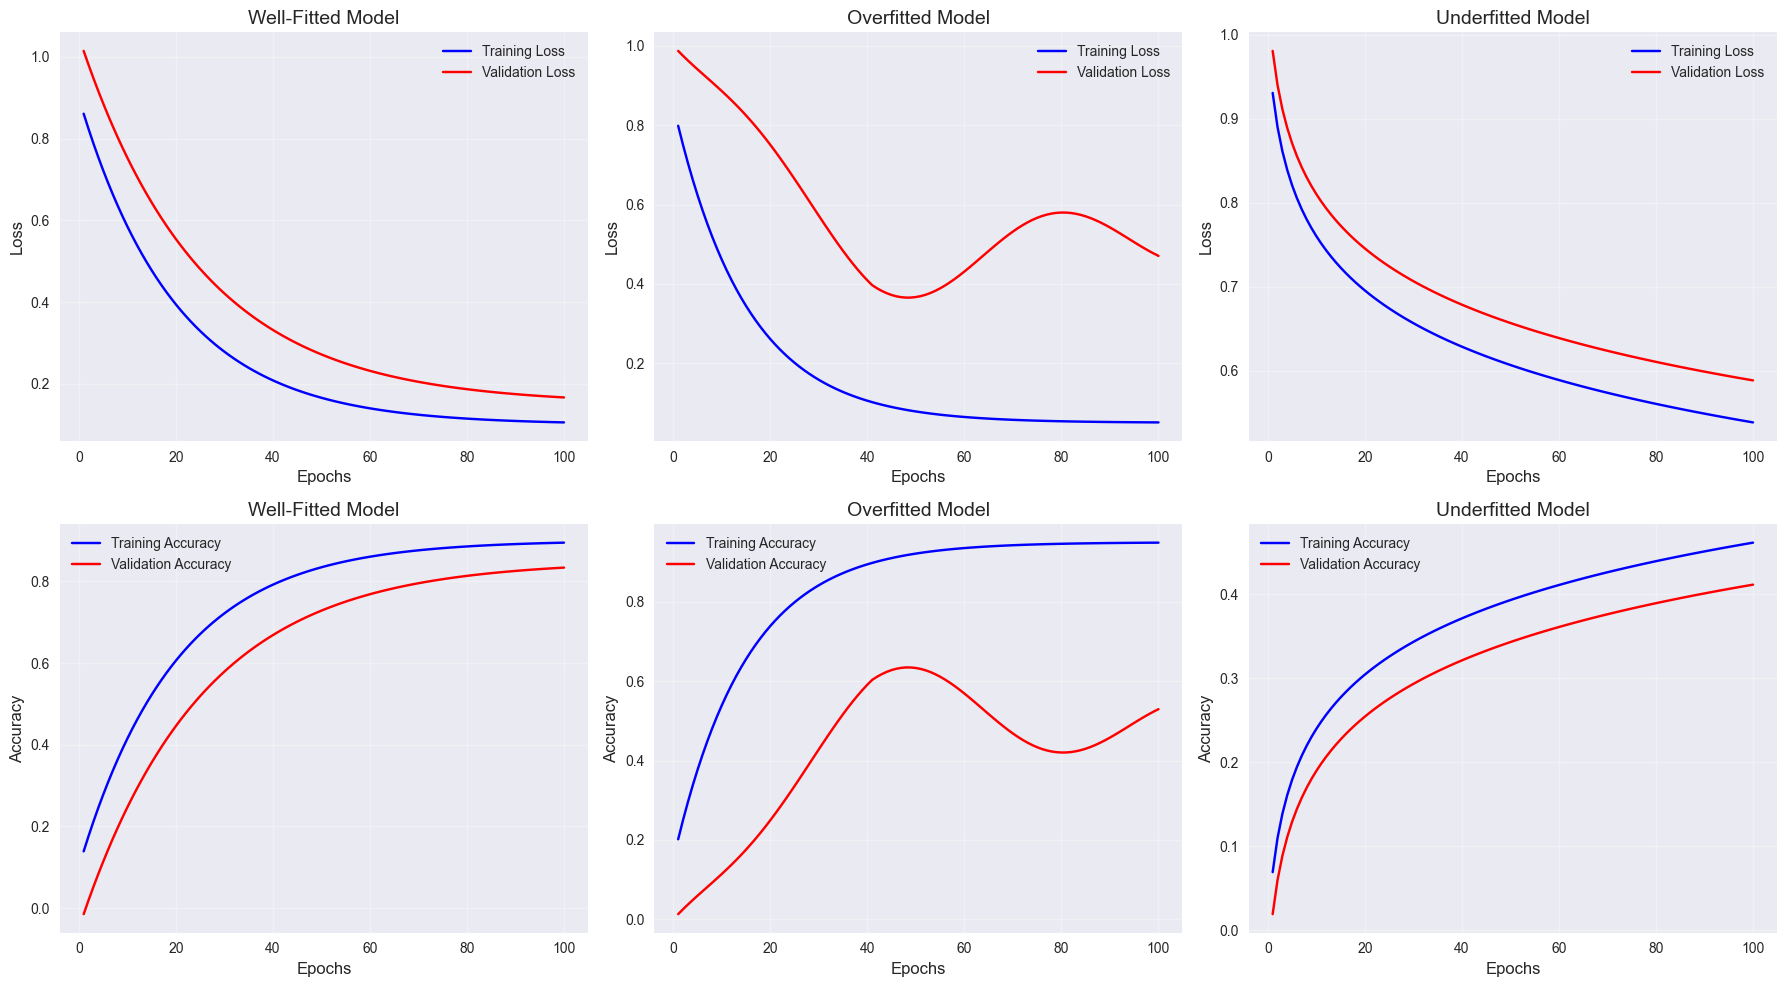


🔍 TRAINING CURVES INTERPRETATION:
----------------------------------------
✅ Well-Fitted: Training and validation curves converge
⚠️  Overfitted: Validation loss increases while training loss decreases
📉 Underfitted: Both curves plateau at high loss/low accuracy


True

In [55]:
# =============================================================================
# 8. TRAINING CURVES ANALYSIS
# =============================================================================

def analyze_training_curves():
    """Analyze training curves to identify overfitting patterns"""
    print("\n" + "=" * 60)
    print("📈 TRAINING CURVES ANALYSIS")
    print("=" * 60)

    # Note: This requires modification of your main training script to save training history
    # For models that support iterative training (like your from-scratch implementations)

    print("💡 IMPLEMENTATION SUGGESTIONS:")
    print("-" * 40)
    print("To complete this analysis, modify your training functions to track:")
    print("1. Training loss/accuracy per epoch/iteration")
    print("2. Validation loss/accuracy per epoch/iteration")
    print("3. Convergence patterns")

    # Conceptual visualization of what training curves should look like
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Simulate different training scenarios
    epochs = np.arange(1, 101)

    # 1. Well-fitted model
    ax1 = axes[0, 0]
    train_loss = 0.8 * np.exp(-epochs/20) + 0.1
    val_loss = 0.9 * np.exp(-epochs/25) + 0.15
    ax1.plot(epochs, train_loss, label='Training Loss', color='blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='red')
    ax1.set_title('Well-Fitted Model')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Overfitted model
    ax2 = axes[0, 1]
    train_loss_over = 0.8 * np.exp(-epochs/15) + 0.05
    val_loss_over = 0.7 * np.exp(-epochs/30) + 0.3 + 0.1 * np.sin(epochs/10)
    val_loss_over[40:] += np.linspace(0, 0.2, len(epochs[40:]))  # Validation loss increases
    ax2.plot(epochs, train_loss_over, label='Training Loss', color='blue')
    ax2.plot(epochs, val_loss_over, label='Validation Loss', color='red')
    ax2.set_title('Overfitted Model')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Underfitted model
    ax3 = axes[0, 2]
    train_loss_under = 0.6 - 0.1 * np.log(epochs + 1) + 0.4
    val_loss_under = 0.65 - 0.1 * np.log(epochs + 1) + 0.4
    ax3.plot(epochs, train_loss_under, label='Training Loss', color='blue')
    ax3.plot(epochs, val_loss_under, label='Validation Loss', color='red')
    ax3.set_title('Underfitted Model')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Corresponding accuracy plots
    # 4. Well-fitted accuracy
    ax4 = axes[1, 0]
    train_acc = 1 - train_loss
    val_acc = 1 - val_loss
    ax4.plot(epochs, train_acc, label='Training Accuracy', color='blue')
    ax4.plot(epochs, val_acc, label='Validation Accuracy', color='red')
    ax4.set_title('Well-Fitted Model')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Overfitted accuracy
    ax5 = axes[1, 1]
    train_acc_over = 1 - train_loss_over
    val_acc_over = 1 - val_loss_over
    ax5.plot(epochs, train_acc_over, label='Training Accuracy', color='blue')
    ax5.plot(epochs, val_acc_over, label='Validation Accuracy', color='red')
    ax5.set_title('Overfitted Model')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Accuracy')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Underfitted accuracy
    ax6 = axes[1, 2]
    train_acc_under = 1 - train_loss_under
    val_acc_under = 1 - val_loss_under
    ax6.plot(epochs, train_acc_under, label='Training Accuracy', color='blue')
    ax6.plot(epochs, val_acc_under, label='Validation Accuracy', color='red')
    ax6.set_title('Underfitted Model')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Accuracy')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n🔍 TRAINING CURVES INTERPRETATION:")
    print("-" * 40)
    print("✅ Well-Fitted: Training and validation curves converge")
    print("⚠️  Overfitted: Validation loss increases while training loss decreases")
    print("📉 Underfitted: Both curves plateau at high loss/low accuracy")

    return True

# Run training curves analysis
analyze_training_curves()
